In [2]:
#For jum002 HPC setup
import sys
import os
sys.path.append("/home/jum002/store5/repo/smrt_fork/smrt")
sys.path.append("/home/jum002/store5/repo/snowmicropyn")
os.chdir("/home/jum002/code-workshop/AKROSS_paper/Code-paper")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#local import 
import akross_common_functions as AK

# import SMRT
# Import saline snow permittivity model
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
#from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09 as ssp
from smrt import make_model
from smrt.inputs import altimeter_list
from smrt.emmodel.iba import derived_IBA

#turn off warning
import warnings
warnings.simplefilter('ignore')

This notebook contains the following 4 sections

1. Prepare simulation
2. Signal contribution (surface, interface and volume)
3. Sensitivity analysis for Ku
4. Sensitivity analysis for Ka

### 1. Prepare simulation

- import profile derived from smp ready to create SMRT simulation.
- CB and Eureka22 an join together to represent FYI. A random subset from eureka (500 snowpacks) is taken of same size from CB. This is just to allow faster simulation.

In [4]:
#CB
#get smp profile for CB
list_smp_CB = pd.read_pickle('smrt_in-out/smp_profile_CB_3cm')
FYI_sp = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14)

#get smp profile for Alert
list_profile_A = pd.read_pickle('smrt_in-out/smp_profile_A_3cm')
MYI_sp = AK.build_snowpack_pickle(list_profile_A, ice_salinity = 5, ice_temp = 260, sea_ice_density = 880, 
                                    ice_type = 'multiyear', sigma_surface= 0.22)

In [5]:
#set mean roughness value for snow and ice from AKROSS campaign

# value of ice optimized per (FYI=  mean of CB-Eureka 22 and Eureka 16, MYI = Alert)
mean_rms_fyi = 0.0021
mean_rms_myi = 0.0056
mean_lc_fyi = 0.4
mean_lc_myi = 0.4

#norm factor from notebook 3.1
normf = 5.899e8


In [6]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(return_contributions=True, theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto"))
cryosat = altimeter_list.cryosat2_sin()
altika = altimeter_list.saral_altika()

### 2. Signal contribution

- investigate signal contribution as a function of ice roughness
- check signal contribution at optimized roughness
- plot the results

In [7]:
2*np.pi*35.75e9/2.8e8 * 0.005

4.011140620208397

In [8]:
def get_contribution(sp, Ka = False):
    altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(return_contributions=True, theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto"))
    if Ka == True:
        sensor = altimeter_list.saral_altika()
    else:
        sensor = altimeter_list.cryosat2_sin()

    res = altimodel.run(sensor, sp, parallel_computation=True).sigma()
    mean_simu = np.mean(res, axis = 0)*normf

    interface = AK.calc_A(mean_simu.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu.sel(contribution = 'total').values) *100
    surface = AK.calc_A(mean_simu.sel(contribution = 'surface').values) / AK.calc_A(mean_simu.sel(contribution = 'total').values) *100
    volume = AK.calc_A(mean_simu.sel(contribution = 'volume').values) / AK.calc_A(mean_simu.sel(contribution = 'total').values) *100

    return interface, surface, volume

In [9]:
#Ku
#investigate contribution as function of roughness
rough_array = np.linspace(0.001,0.008, 10)
rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:

    #change rough
    AK.change_roughness(MYI_sp, rough, mean_lc_myi, rough, mean_lc_myi)
    AK.change_roughness(FYI_sp, rough, mean_lc_fyi, rough, mean_lc_fyi)

    #simulate Ku
    interface_myi_ku, surface_myi_ku, volume_myi_ku = get_contribution(MYI_sp, Ka = False)
    interface_fyi_ku, surface_fyi_ku, volume_fyi_ku = get_contribution(FYI_sp, Ka = False)

    rough_contribution_A.append({'interface': interface_myi_ku, 'surface' : surface_myi_ku, 'volume' : volume_myi_ku})
    rough_contribution_CB.append({'interface': interface_fyi_ku, 'surface' : surface_fyi_ku, 'volume' : volume_fyi_ku})

rough_df_A_ku = pd.DataFrame(rough_contribution_A)
rough_df_CB_ku = pd.DataFrame(rough_contribution_CB)

In [10]:
#Ka 
#investigate contribution as function of roughness

rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:
    #print(rough)
    #change rough
    AK.change_roughness(MYI_sp, rough, mean_lc_myi, rough, mean_lc_myi)
    AK.change_roughness(FYI_sp, rough, mean_lc_fyi, rough, mean_lc_fyi)

    #simulate ka
    interface_myi_ka, surface_myi_ka, volume_myi_ka = get_contribution(MYI_sp, Ka = True)
    interface_fyi_ka, surface_fyi_ka, volume_fyi_ka = get_contribution(FYI_sp, Ka = True)

    rough_contribution_A.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
    rough_contribution_CB.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})
    
rough_df_A_ka_iem = pd.DataFrame(rough_contribution_A)
rough_df_CB_ka_iem = pd.DataFrame(rough_contribution_CB)

Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.01533
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.02405
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.08566
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.00056
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.06052
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.07304
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.1453
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.28578
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.28416
Warning, roughness_rms is too high for the given wavelength. Limit is ks < 3. Here ks=3.26481
Warning, roughness_rms is too high for the given wavelength. 

In [11]:
#Ka 
#investigate contribution as function of roughness

rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:
    print(rough)
    #change rough
    AK.change_roughness_geo(MYI_sp, rough, mean_lc_myi, rough, mean_lc_myi)
    AK.change_roughness_geo(FYI_sp, rough, mean_lc_fyi, rough, mean_lc_fyi)

    #simulate Ka
    interface_myi_ka, surface_myi_ka, volume_myi_ka = get_contribution(MYI_sp, Ka = True)
    interface_fyi_ka, surface_fyi_ka, volume_fyi_ka = get_contribution(FYI_sp, Ka = True)

    rough_contribution_A.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
    rough_contribution_CB.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})
    
rough_df_A_ka_geo = pd.DataFrame(rough_contribution_A)
rough_df_CB_ka_geo = pd.DataFrame(rough_contribution_CB)

0.001


/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_o

0.0017777777777777779
0.0025555555555555557
0.0033333333333333335
0.004111111111111111
0.004888888888888889
0.005666666666666667
0.0064444444444444445
0.007222222222222223
0.008


get contribution at optimized roughness

In [12]:
#Ku
#change rough to opti values
AK.change_roughness(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

#simulate Ku 
interface_myi_ku, surface_myi_ku, volume_myi_ku = get_contribution(MYI_sp, Ka = False)
interface_fyi_ku, surface_fyi_ku, volume_fyi_ku = get_contribution(FYI_sp, Ka = False)

In [13]:
#Ka
#add salt for Alert
AK.change_roughness_geo(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness_geo(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

#simulate Ku and Ka
interface_myi_ka, surface_myi_ka, volume_myi_ka = get_contribution(MYI_sp, Ka = True)
interface_fyi_ka, surface_fyi_ka, volume_fyi_ka = get_contribution(FYI_sp, Ka = True)

In [14]:
#Ka
#add salt for Alert
AK.change_roughness(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

#simulate Ku and Ka
interface_myi_ka_iem, surface_myi_ka_iem, volume_myi_ka_iem = get_contribution(MYI_sp, Ka = True)
interface_fyi_ka_iem, surface_fyi_ka_iem, volume_fyi_ka_iem = get_contribution(FYI_sp, Ka = True)

In [15]:
from smrt.core.globalconstants import C_SPEED
# find limit of surface model
k = 2*np.pi*13.575e9/C_SPEED
s_k_geo = 1/k
s_k_iem = 3/k
print(f'Ku : limit IEM {s_k_iem}, start GO {s_k_geo},')
k = 2*np.pi*35.75e9/C_SPEED
s_k_geo = 1/k
s_k_iem = 3/k
print(f'Ka: limit IEM {s_k_iem}, start GO {s_k_geo},')

Ku : limit IEM 0.010544409191683849, start GO 0.003514803063894616,
Ka: limit IEM 0.00400392600775128, start GO 0.0013346420025837603,


plot the results

In [16]:
df = pd.DataFrame({'Ice type - sensor' : ['CB-22\n Ku-IEM', 'Alert-17\n Ku-IEM', 'CB-22\n Ka-GO', 'Alert-17\n Ka-GO', 'CB-22\n Ka-IEM', 'Alert-17\n Ka-IEM'], 
             'surface': [surface_fyi_ku, surface_myi_ku, surface_fyi_ka, surface_myi_ka, surface_fyi_ka_iem, surface_myi_ka_iem],
             'interface' : [interface_fyi_ku, interface_myi_ku, interface_fyi_ka, interface_myi_ka, interface_fyi_ka_iem, interface_myi_ka_iem],
             'volume' : [volume_fyi_ku, volume_myi_ku, volume_fyi_ka, volume_myi_ka, volume_fyi_ka_iem, volume_myi_ka_iem] })

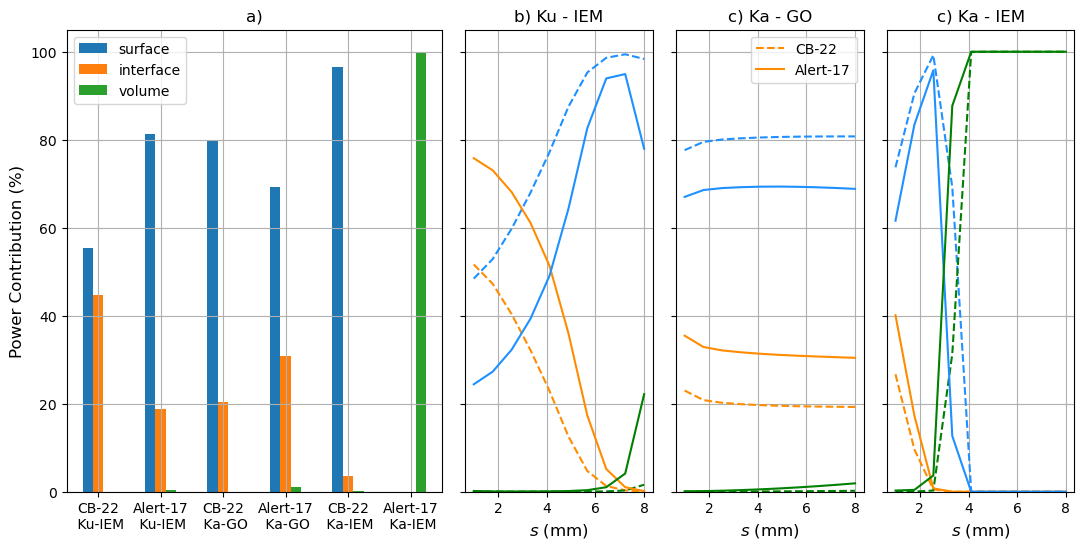

In [17]:
plt.rcParams.update({'font.size': 10})
fig, (ax1, ax2, ax3, ax4)  = plt.subplots(nrows=1, ncols=4, figsize=(13,6), gridspec_kw={'width_ratios': [2, 1, 1, 1]}, sharey = True)
df.plot(
    x = 'Ice type - sensor',
    kind = 'bar',
    stacked = False,
    title = 'a)',
    ax =ax1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, ha='center')
#ax1.set_xlabel('Backscatter Contribution (%)', size =14)
ax1.set_ylabel('Power Contribution (%)', size =12)

ax2.plot(rough_array*1000,rough_df_CB_ku.interface,'--', label = 'CB-22', color = 'darkorange')
ax2.plot(rough_array*1000,rough_df_CB_ku.surface,'--', color = 'dodgerblue')
ax2.plot(rough_array*1000,rough_df_CB_ku.volume,'--', color = 'green')
ax2.plot(rough_array*1000,rough_df_A_ku.interface, label = 'Alert-17', color = 'darkorange')
ax2.plot(rough_array*1000,rough_df_A_ku.surface, color = 'dodgerblue')
ax2.plot(rough_array*1000,rough_df_A_ku.volume, color = 'green')
ax2.set_title('b) Ku - IEM')
ax2.set_xlabel('$s$ (mm)', size =12)
#ax2.set_ylabel('Backscatter Contribution (%)', size =12)
ax2.grid()


ax3.plot(rough_array*1000,rough_df_CB_ka_geo.interface,'--', label = 'CB-22', color = 'darkorange')
ax3.plot(rough_array*1000,rough_df_CB_ka_geo.surface,'--', color = 'dodgerblue')
ax3.plot(rough_array*1000,rough_df_CB_ka_geo.volume,'--', color = 'green')
ax3.legend()
ax3.plot(rough_array*1000,rough_df_A_ka_geo.interface, label = 'Alert-17', color = 'darkorange')
ax3.plot(rough_array*1000,rough_df_A_ka_geo.surface, color = 'dodgerblue')
ax3.plot(rough_array*1000,rough_df_A_ka_geo.volume, color = 'green')
ax3.legend()
ax3.set_title('c) Ka - GO')
ax3.set_xlabel('$s$ (mm)', size =12)
#ax3.set_ylabel('Backscatter Contribution (%)', size =12)
ax3.grid()

ax4.plot(rough_array*1000,rough_df_CB_ka_iem.interface,'--', label = 'CB-22', color = 'darkorange')
ax4.plot(rough_array*1000,rough_df_CB_ka_iem.surface,'--', color = 'dodgerblue')
ax4.plot(rough_array*1000,rough_df_CB_ka_iem.volume,'--', color = 'green')
ax4.plot(rough_array*1000,rough_df_A_ka_iem.interface, label = 'Alert-17', color = 'darkorange')
ax4.plot(rough_array*1000,rough_df_A_ka_iem.surface, color = 'dodgerblue')
ax4.plot(rough_array*1000,rough_df_A_ka_iem.volume, color = 'green')
ax4.set_title('c) Ka - IEM')
ax4.set_xlabel('$s$ (mm)', size =12)
#ax3.set_ylabel('Backscatter Contribution (%)', size =12)
ax4.grid()
plt.subplots_adjust(wspace = 0.1)
#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/contribution_Ku_ka.png', dpi=300, format='png', bbox_inches='tight')

In [18]:
MYI_sp[0].layers[0].microstructure.corr_length

5.72487237929913e-05

In [19]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
ssa_contribution_A_ku, ssa_contribution_CB_ku = [], []
ssa_contribution_A_ka, ssa_contribution_CB_ka = [], []
ratio_ssa_array = np.linspace(0.5, 1.5, 10)
for ratio_ssa in ratio_ssa_array:

    #simulate Ku
    CB_ssa = AK.change_snowpack(ratio_ssa, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14)
    A_ssa = AK.change_snowpack(ratio_ssa, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22)
    interface_myi_ku, surface_myi_ku, volume_myi_ku = get_contribution(A_ssa, Ka = False)
    interface_fyi_ku, surface_fyi_ku, volume_fyi_ku = get_contribution(CB_ssa, Ka = False)

    #simulate Ka
    CB_ssa = AK.change_snowpack(ratio_ssa, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
    A_ssa = AK.change_snowpack(ratio_ssa, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)
    interface_myi_ka, surface_myi_ka, volume_myi_ka = get_contribution(A_ssa, Ka = True)
    interface_fyi_ka, surface_fyi_ka, volume_fyi_ka = get_contribution(CB_ssa, Ka = True)

    ssa_contribution_A_ku.append({'interface': interface_myi_ku, 'surface' : surface_myi_ku, 'volume' : volume_myi_ku})
    ssa_contribution_CB_ku.append({'interface': interface_fyi_ku, 'surface' : surface_fyi_ku, 'volume' : volume_fyi_ku})

    ssa_contribution_A_ka.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
    ssa_contribution_CB_ka.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})

ssa_df_A_ku = pd.DataFrame(ssa_contribution_A_ku)
ssa_df_CB_ku = pd.DataFrame(ssa_contribution_CB_ku)

ssa_df_A_ka = pd.DataFrame(ssa_contribution_A_ka)
ssa_df_CB_ka = pd.DataFrame(ssa_contribution_CB_ka)

In [20]:
# #density
# #call snowpack fromm scratch with build_snowpack so FYI_sp not modify
# density_contribution_A_ku, density_contribution_CB_ku = [], []
# density_contribution_A_ka, density_contribution_CB_ka = [], []
# ratio_density_array = np.linspace(0.5, 1.5, 10)
# for ratio_density in ratio_density_array:
#     #simulate Ku
#     CB_density = AK.change_snowpack(ratio_density, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'density', sigma_surface=0.14)
#     A_density = AK.change_snowpack(ratio_density, MYI_sp, mean_rms_myi, mean_lc_myi, 'density', sigma_surface=0.22)
#     interface_myi_ku, surface_myi_ku, volume_myi_ku = get_contribution(A_density, Ka = False)
#     interface_fyi_ku, surface_fyi_ku, volume_fyi_ku = get_contribution(CB_density, Ka = False)

#     #simulate Ka
#     CB_density = AK.change_snowpack(ratio_density, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'density', sigma_surface=0.14, Ka = True)
#     A_density = AK.change_snowpack(ratio_density, MYI_sp, mean_rms_myi, mean_lc_myi, 'density', sigma_surface=0.22, Ka = True)
#     interface_myi_ka, surface_myi_ka, volume_myi_ka = get_contribution(A_density, Ka = True)
#     interface_fyi_ka, surface_fyi_ka, volume_fyi_ka = get_contribution(CB_density, Ka = True)

#     density_contribution_A_ku.append({'interface': interface_myi_ku, 'surface' : surface_myi_ku, 'volume' : volume_myi_ku})
#     density_contribution_CB_ku.append({'interface': interface_fyi_ku, 'surface' : surface_fyi_ku, 'volume' : volume_fyi_ku})

#     density_contribution_A_ka.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
#     density_contribution_CB_ka.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})

# density_df_A_ku = pd.DataFrame(density_contribution_A_ku)
# density_df_CB_ku = pd.DataFrame(density_contribution_CB_ku)

# density_df_A_ka = pd.DataFrame(density_contribution_A_ka)
# density_df_CB_ka = pd.DataFrame(density_contribution_CB_ka)

In [21]:
#salt
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
salt_contribution_A_ku, salt_contribution_CB_ku = [], []
salt_contribution_A_ka, salt_contribution_CB_ka = [], []
ratio_salt_array = np.linspace(0.5, 1.5, 10)
for ratio_salt in ratio_salt_array:
    #simulate Ku
    CB_salt = AK.change_snowpack(ratio_salt, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14)
    A_salt = AK.change_snowpack(ratio_salt, MYI_sp, mean_rms_myi, mean_lc_myi, 'salinity', sigma_surface=0.22)
    interface_myi_ku, surface_myi_ku, volume_myi_ku = get_contribution(A_salt, Ka = False)
    interface_fyi_ku, surface_fyi_ku, volume_fyi_ku = get_contribution(CB_salt, Ka = False)

    #simulate Ka
    CB_salt = AK.change_snowpack(ratio_salt, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14, Ka = True)
    A_salt = AK.change_snowpack(ratio_salt, MYI_sp, mean_rms_myi, mean_lc_myi, 'salinity', sigma_surface=0.22, Ka = True)
    interface_myi_ka, surface_myi_ka, volume_myi_ka = get_contribution(A_salt, Ka = True)
    interface_fyi_ka, surface_fyi_ka, volume_fyi_ka = get_contribution(CB_salt, Ka = True)

    salt_contribution_A_ku.append({'interface': interface_myi_ku, 'surface' : surface_myi_ku, 'volume' : volume_myi_ku})
    salt_contribution_CB_ku.append({'interface': interface_fyi_ku, 'surface' : surface_fyi_ku, 'volume' : volume_fyi_ku})

    salt_contribution_A_ka.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
    salt_contribution_CB_ka.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})

salt_df_A_ku = pd.DataFrame(salt_contribution_A_ku)
salt_df_CB_ku = pd.DataFrame(salt_contribution_CB_ku)

salt_df_A_ka = pd.DataFrame(salt_contribution_A_ka)
salt_df_CB_ka = pd.DataFrame(salt_contribution_CB_ka)

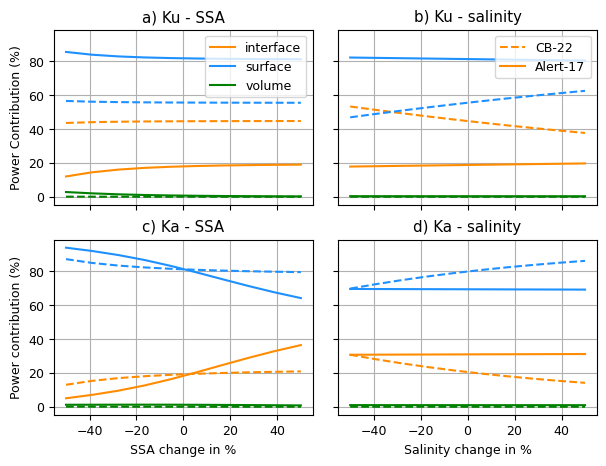

In [22]:
plt.rcParams.update({'font.size': 9})
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(nrows=2, ncols=2, figsize=(7,5), sharey = True, sharex = True)


ax1.plot((ratio_ssa_array-1)*100, ssa_df_CB_ku.interface,'--', color = 'darkorange')
ax1.plot((ratio_ssa_array-1)*100, ssa_df_CB_ku.surface,'--', color = 'dodgerblue')
ax1.plot((ratio_ssa_array-1)*100, ssa_df_CB_ku.volume,'--', color = 'green')
ax1.plot((ratio_ssa_array-1)*100, ssa_df_A_ku.interface, color = 'darkorange', label = 'interface')
ax1.plot((ratio_ssa_array-1)*100, ssa_df_A_ku.surface, color = 'dodgerblue', label = 'surface')
ax1.plot((ratio_ssa_array-1)*100 ,ssa_df_A_ku.volume, color = 'green', label = 'volume')
ax1.set_title('a) Ku - SSA')
ax1.set_ylabel('Power Contribution (%)')
ax1.grid()
ax1.legend()

ax2.plot((ratio_salt_array-1)*100,salt_df_CB_ku.interface,'--', label = 'CB-22', color = 'darkorange')
ax2.plot((ratio_salt_array-1)*100,salt_df_CB_ku.surface,'--', color = 'dodgerblue')
ax2.plot((ratio_salt_array-1)*100,salt_df_CB_ku.volume,'--', color = 'green')
ax2.plot((ratio_salt_array-1)*100,salt_df_A_ku.interface, label = 'Alert-17', color = 'darkorange')
ax2.plot((ratio_salt_array-1)*100,salt_df_A_ku.surface, color = 'dodgerblue')
ax2.plot((ratio_salt_array-1)*100,salt_df_A_ku.volume, color = 'green')
ax2.legend()
ax2.set_title('b) Ku - salinity')
#ax2.set_ylabel('Backscatter Contribution (%)', size =12)
ax2.grid()

ax3.plot((ratio_ssa_array-1)*100, ssa_df_CB_ka.interface,'--', label = 'CB-22', color = 'darkorange')
ax3.plot((ratio_ssa_array-1)*100, ssa_df_CB_ka.surface,'--', color = 'dodgerblue')
ax3.plot((ratio_ssa_array-1)*100, ssa_df_CB_ka.volume,'--', color = 'green')
ax3.plot((ratio_ssa_array-1)*100, ssa_df_A_ka.interface, label = 'Alert-17', color = 'darkorange')
ax3.plot((ratio_ssa_array-1)*100, ssa_df_A_ka.surface, color = 'dodgerblue')
ax3.plot((ratio_ssa_array-1)*100 ,ssa_df_A_ka.volume, color = 'green')
ax3.set_title('c) Ka - SSA')
ax3.set_xlabel('SSA change in %')
ax3.set_ylabel('Power contribution (%)')
ax3.grid()


ax4.plot((ratio_salt_array-1)*100,salt_df_CB_ka.interface,'--', label = 'CB-22', color = 'darkorange')
ax4.plot((ratio_salt_array-1)*100,salt_df_CB_ka.surface,'--', color = 'dodgerblue')
ax4.plot((ratio_salt_array-1)*100,salt_df_CB_ka.volume,'--', color = 'green')
ax4.plot((ratio_salt_array-1)*100,salt_df_A_ka.interface, label = 'Alert-17', color = 'darkorange')
ax4.plot((ratio_salt_array-1)*100,salt_df_A_ka.surface, color = 'dodgerblue')
ax4.plot((ratio_salt_array-1)*100,salt_df_A_ka.volume, color = 'green')
ax4.set_title('d) Ka - salinity')
ax4.set_xlabel('Salinity change in %')
#ax4.set_ylabel('Backscatter Contribution (%)', size =12)
ax4.grid()

# ax5.plot(ratio_density_array,density_df_CB_ku.interface,'--', label = 'CB 22', color = 'darkorange')
# ax5.plot(ratio_density_array,density_df_CB_ku.surface,'--', color = 'dodgerblue')
# ax5.plot(ratio_density_array,density_df_CB_ku.volume,'--', color = 'green')
# ax5.plot(ratio_density_array,density_df_A_ku.interface, label = 'Alert 17', color = 'darkorange')
# ax5.plot(ratio_density_array,density_df_A_ku.surface, color = 'dodgerblue')
# ax5.plot(ratio_density_array,density_df_A_ku.volume, color = 'green')
# ax5.set_title('b) Ku - density')
# #ax5.set_ylabel('Backscatter Contribution (%)', size =12)
# ax5.grid()

# ax6.plot(ratio_density_array,density_df_CB_ka.interface,'--', label = 'CB 22', color = 'darkorange')
# ax6.plot(ratio_density_array,density_df_CB_ka.surface,'--', color = 'dodgerblue')
# ax6.plot(ratio_density_array,density_df_CB_ka.volume,'--', color = 'green')
# ax6.plot(ratio_density_array,density_df_A_ka.interface, label = 'Alert 17', color = 'darkorange')
# ax6.plot(ratio_density_array,density_df_A_ka.surface, color = 'dodgerblue')
# ax6.plot(ratio_density_array,density_df_A_ka.volume, color = 'green')
# ax6.set_title('c) Ka - density')
# ax6.set_xlabel('$s$ (mm)', size =12)
# #ax2.set_ylabel('Contribution (%)', size =12)
# ax6.grid()

plt.subplots_adjust(wspace = 0.1)
#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/contribution_Ku_ka.png', dpi=300, format='png', bbox_inches='tight')

### 3. sensitivity analysis for Ku

- New simulation are produced, introducing a variation (i.e ± 5 K for temperature) from the measured data (simulation intoduced earlier)
- A lot of functions are introduced to be able to regenerate modified simulation. Some parameters needed different function and tricks to achieve
- Results are plotted against simulation introduced earlier in section 3.1


Create modified snowpack

In [39]:
#reset roughness to IEM for Ku
AK.change_roughness(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

cryosat = altimeter_list.cryosat2_sin()
res_CB = altimodel.run(cryosat, FYI_sp, parallel_computation=True).sigma()
res_A = altimodel.run(cryosat, MYI_sp, parallel_computation=True).sigma()
mean_simu_CB_Ku = np.mean(res_CB, axis = 0)*normf
mean_simu_A_Ku = np.mean(res_A, axis = 0)*normf

In [24]:
#Depth
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_depth_p50 = AK.change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14)
CB_depth_m50 = AK.change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14)

#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_depth_p50 = AK.change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22)
A_depth_m50 = AK.change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22)

In [25]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_ssa_p20 = AK.change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14)
CB_ssa_m20 = AK.change_snowpack(0.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_ssa_p20 = AK.change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22)
A_ssa_m20 = AK.change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22)

In [26]:
#temperature
CB_temp_p10 = AK.change_density_temp(FYI_sp, 1, 5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
CB_temp_m10 = AK.change_density_temp(FYI_sp, 1, -5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
A_temp_p10 = AK.change_density_temp(MYI_sp, 1, 5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
A_temp_m10 = AK.change_density_temp(MYI_sp, 1, -5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
# CB_temp_p10 = AK.change_density_temp(FYI_sp, 1, 10, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
# CB_temp_m10 = AK.change_density_temp(FYI_sp, 1, -10, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
# A_temp_p10 = AK.change_density_temp(MYI_sp, 1, 10, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
# A_temp_m10 = AK.change_density_temp(MYI_sp, 1, -10, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)

In [27]:
#Density
CB_density_p50 = AK.change_density_temp(FYI_sp, 1.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
CB_density_m50 = AK.change_density_temp(FYI_sp, 0.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
A_density_p50 = AK.change_density_temp(MYI_sp, 1.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
A_density_m50 = AK.change_density_temp(MYI_sp, 0.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)

In [28]:
#Salt of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_salt_p50 = AK.change_snowpack(1.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14)
CB_salt_m50 = AK.change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_salt_p50 = AK.change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi,'salinity', sigma_surface=0.22)
A_salt_m50 = AK.change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi,'salinity', sigma_surface=0.22)

In [29]:
                
#roughness
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_s_p1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi + 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14)
CB_rough_s_m1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi - 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_s_p1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi + 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22)
A_rough_s_m1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi - 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22)

In [30]:
#roughness
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_l_p1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi+ 0.1, 'ssa', sigma_surface=0.14)
CB_rough_l_m1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi- 0.1, 'ssa', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_l_p1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi + 0.1, 'ssa', sigma_surface=0.22)
A_rough_l_m1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi - 0.1, 'ssa', sigma_surface=0.22)

In [31]:
# #sigma surface
# #call snowpack fromm scratch with build_snowpack so FYI_sp not modify
# CB_rough_l_p1 = change_snowpack(1, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.0)
# CB_rough_l_m1 = change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.8)

# #call snowpack fromm scratch with build_snowpack so A_sp not modify
# A_rough_l_p1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.02)
# A_rough_l_m1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.8)

In [32]:
#ice volume fration
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify

CB_vf_p1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*1.5)
CB_vf_m1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*0.5)
AK.change_roughness(CB_vf_p1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
AK.change_roughness(CB_vf_m1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_vf_p1 = AK.build_snowpack_pickle(list_profile_A, sea_ice_density = 917, ice_type = 'multiyear', sigma_surface= 0.22)
A_vf_m1 = AK.build_snowpack_pickle(list_profile_A, sea_ice_density = 880*0.95, ice_type = 'multiyear', sigma_surface= 0.22)
AK.change_roughness(A_vf_p1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(A_vf_m1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)

In [33]:
#reduce layers
CB_one = AK.reduce_layer(FYI_sp, 'one', 'FYI', mean_rms= mean_rms_fyi, mean_lc = mean_lc_fyi)
CB_three = AK.reduce_layer(FYI_sp, 'three', 'FYI', mean_rms= mean_rms_fyi, mean_lc = mean_lc_fyi)
A_one = AK.reduce_layer(MYI_sp, 'one', 'MYI', mean_rms= mean_rms_myi, mean_lc = mean_lc_myi)
A_three = AK.reduce_layer(MYI_sp, 'three', 'MYI', mean_rms= mean_rms_myi, mean_lc = mean_lc_myi)

get modified waveform from modified snowpack

In [34]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto"))
cryosat = altimeter_list.cryosat2_sin()
res_CB_Ku_depth_p50 = np.mean(altimodel.run(cryosat, CB_depth_p50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_depth_m50 = np.mean(altimodel.run(cryosat, CB_depth_m50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_depth_p50 = np.mean(altimodel.run(cryosat, A_depth_p50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_depth_m50 = np.mean(altimodel.run(cryosat, A_depth_m50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_ssa_p20 = np.mean(altimodel.run(cryosat, CB_ssa_p20, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_ssa_m20 = np.mean(altimodel.run(cryosat, CB_ssa_m20, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_ssa_p20 = np.mean(altimodel.run(cryosat, A_ssa_p20, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_ssa_m20 = np.mean(altimodel.run(cryosat, A_ssa_m20, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_temp_p10 = np.mean(altimodel.run(cryosat, CB_temp_p10, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_temp_m10 = np.mean(altimodel.run(cryosat, CB_temp_m10, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_temp_p10 = np.mean(altimodel.run(cryosat, A_temp_p10, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_temp_m10 = np.mean(altimodel.run(cryosat, A_temp_m10, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_density_p50 = np.mean(altimodel.run(cryosat, CB_density_p50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_density_m50 = np.mean(altimodel.run(cryosat, CB_density_m50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_density_p50 = np.mean(altimodel.run(cryosat, A_density_p50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_density_m50 = np.mean(altimodel.run(cryosat, A_density_m50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_salt_p50 = np.mean(altimodel.run(cryosat, CB_salt_p50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_salt_m50 = np.mean(altimodel.run(cryosat, CB_salt_m50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_salt_p50 = np.mean(altimodel.run(cryosat, A_salt_p50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_salt_m50 = np.mean(altimodel.run(cryosat, A_salt_m50, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_rough_s_p1 = np.mean(altimodel.run(cryosat, CB_rough_s_p1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_rough_s_m1 = np.mean(altimodel.run(cryosat, CB_rough_s_m1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_rough_s_p1 = np.mean(altimodel.run(cryosat, A_rough_s_p1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_rough_s_m1 = np.mean(altimodel.run(cryosat, A_rough_s_m1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_rough_l_p1 = np.mean(altimodel.run(cryosat, CB_rough_l_p1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_rough_l_m1 = np.mean(altimodel.run(cryosat, CB_rough_l_m1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_rough_l_p1 = np.mean(altimodel.run(cryosat, A_rough_l_p1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_rough_l_m1 = np.mean(altimodel.run(cryosat, A_rough_l_m1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_vf_p1 = np.mean(altimodel.run(cryosat, CB_vf_p1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_vf_m1 = np.mean(altimodel.run(cryosat, CB_vf_m1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_vf_p1 = np.mean(altimodel.run(cryosat, A_vf_p1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_vf_m1 = np.mean(altimodel.run(cryosat, A_vf_m1, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

res_CB_Ku_one = np.mean(altimodel.run(cryosat, CB_one, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_CB_Ku_three = np.mean(altimodel.run(cryosat, CB_three, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_one = np.mean(altimodel.run(cryosat, A_one, parallel_computation=True).sigma(), axis = 0)*normf/1e-14
res_A_Ku_three = np.mean(altimodel.run(cryosat, A_three, parallel_computation=True).sigma(), axis = 0)*normf/1e-14

plot results

In [40]:
mean_simu_CB_Ku

<xarray.DataArray (t_gate: 512)>
array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
...
       1.17769469e-16, 1.15685570e-16, 1.13637467e-16, 1.11624560e-16,
       1.09646255e-16, 1.07701972e-16, 1.05791138e-16, 1.03913190e-16,
       1.02067574e-16, 1.00253745e-16, 9.84711690e-17, 9.67193184e-17,
       9.49976756e-17, 9.33057313e-17, 9.16429847e-17, 9.00089431e-17,
       8.84266042e-17, 8.69167931e-17, 8.54368651e-17, 8.39817452e-17,
       8.25509320e-17, 8.11440255e-17, 7.97606321e-17, 7.84003648e-17,
       7.70628428e-17, 7.57476914e-17, 7.44545422e-17, 7.31830326e-17,
       7.19328060e-17, 7.07035116e-17, 6.94948043e-17, 6.83063447e-17,
       6.71377988e-17, 6.59888381e-17, 6.48591394e-17, 6.37483849e-17,
       6.26562618e-17, 6.15824626e-17, 6.05266847e-17, 5.94886303e-17,
       5.84680068e-17, 5.74645260e-17, 5.64779047e-17, 5.55078642e-17,
       5.45541303e-17, 5.36164332e-17, 5.26945079e-17, 5.17880932e-17,
       5.08969326e-17, 5.00207736e-17, 4.91593677e-17, 4.83124707e-17,
       4.74798422e-17, 4.66612460e-17, 4.58564494e-17, 4.50652238e-17,
       4.42873441e-17, 4.35225892e-17, 4.27707412e-17, 4.20315862e-17,
       4.13049134e-17, 4.05905158e-17, 3.98881896e-17, 3.91977342e-17,
       3.85189527e-17, 3.78516510e-17, 3.71956385e-17, 3.65507275e-17,
       3.59167334e-17, 3.52934748e-17, 3.46807731e-17, 3.40784528e-17,
       3.34863410e-17, 3.29042679e-17, 3.23320663e-17, 3.17695720e-17,
       3.12166232e-17, 3.06730609e-17, 3.01387287e-17, 2.96134728e-17])
Coordinates:
    theta_inc  int64 0
  * t_gate     (t_gate) float64 0.0 3.125e-09 6.25e-09 ... 1.594e-06 1.597e-06
    theta      int64 0

(0.1, 10)

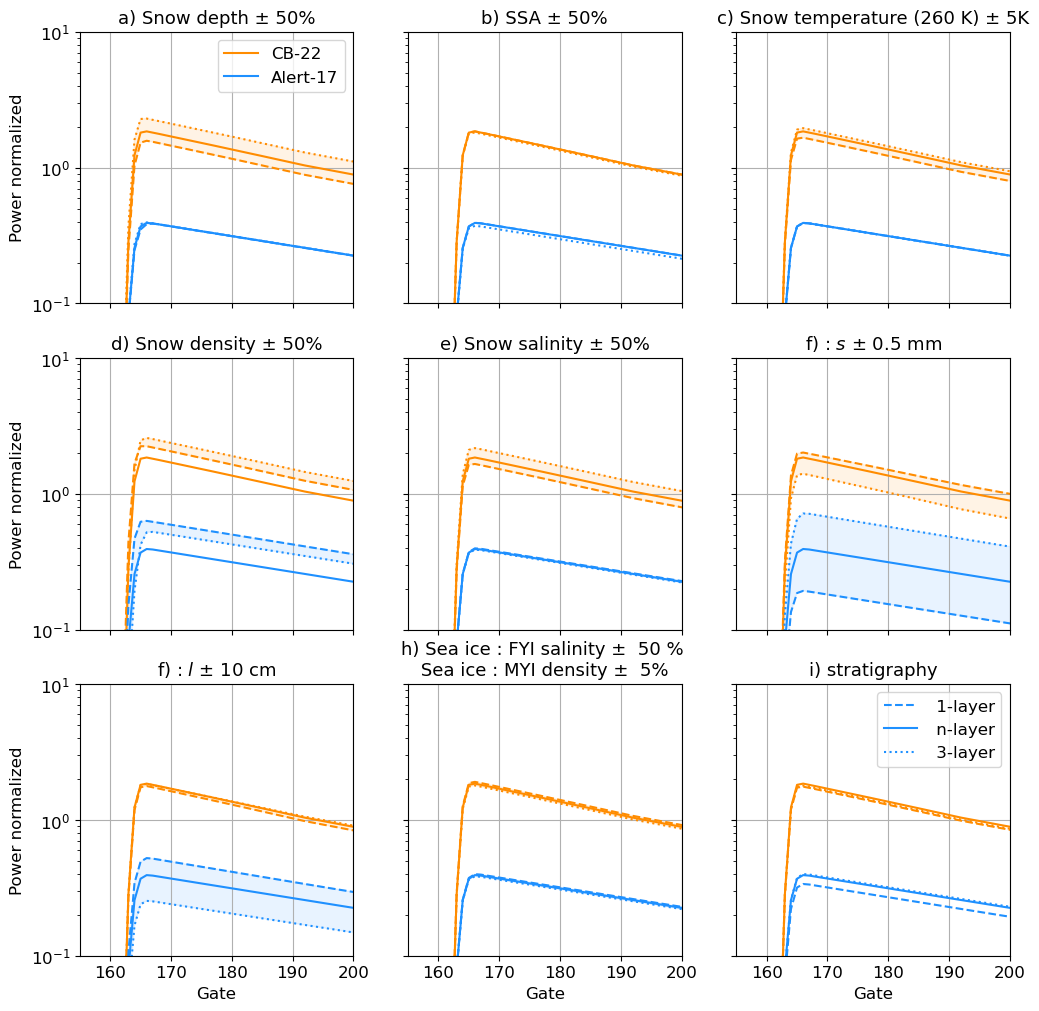

In [54]:
#generate x fro number of bins
x = range(0,len(res_CB_Ku_depth_p50))

# Plot results
plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(12,12),
                                                                         sharey =True, sharex = True)
plt.rcParams.update({'font.size': 12})
ax1.set_title('a) Snow depth ± 50%', size = 13)
ax1.plot(res_CB_Ku_depth_p50, linestyle = '--',color = 'darkorange')
ax1.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange', label = 'CB-22')
ax1.plot(res_CB_Ku_depth_m50, linestyle = ':',color = 'darkorange')
ax1.fill_between(x, y1 = res_CB_Ku_depth_p50, y2 = res_CB_Ku_depth_m50, alpha =0.1, color = 'darkorange')

ax1.plot(res_A_Ku_depth_p50, linestyle = '--',color = 'dodgerblue')
ax1.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = 'Alert-17')
ax1.plot(res_A_Ku_depth_m50, linestyle = ':',color = 'dodgerblue')
ax1.fill_between(x, y1 = res_A_Ku_depth_p50, y2 = res_A_Ku_depth_m50, alpha =0.1, color = 'dodgerblue')
ax1.legend()
ax1.set_xlim(155,190)
ax1.set_ylabel('Power normalized')
ax1.set_yscale('log')
ax1.grid()


ax2.set_title('b) SSA ± 50%', size = 13)
ax2.plot(res_CB_Ku_ssa_p20, linestyle = '--',color = 'darkorange')
ax2.plot(mean_simu_CB_Ku/1e-14,color = 'darkorange', label = 'FYI ± 50%')
ax2.plot(res_CB_Ku_ssa_m20, linestyle = ':',color = 'darkorange')

ax2.plot(res_A_Ku_ssa_p20, linestyle = '--',color = 'dodgerblue')
ax2.plot(mean_simu_A_Ku/1e-14,color = 'dodgerblue', label = 'MYI ± 50%')
ax2.plot(res_A_Ku_ssa_m20, linestyle = ':',color = 'dodgerblue')
#ax2.legend()
ax2.grid()
ax2.set_xlim(155,190)


ax3.set_title('c) Snow temperature (260 K) ± 5K', size = 13)
ax3.plot(res_CB_Ku_temp_p10, linestyle = '--',color = 'darkorange')
ax3.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange')
ax3.plot(res_CB_Ku_temp_m10, linestyle = ':',color = 'darkorange')
ax3.fill_between(x, y1 = res_CB_Ku_temp_p10, y2 = res_CB_Ku_temp_m10, alpha =0.1, color = 'darkorange')

ax3.plot(res_A_Ku_temp_p10, linestyle = '--',color = 'dodgerblue')
ax3.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue')
ax3.plot(res_A_Ku_temp_m10, linestyle = ':',color = 'dodgerblue')
ax3.fill_between(x, y1 = res_A_Ku_temp_p10, y2 = res_A_Ku_temp_m10, alpha =0.1, color = 'dodgerblue')
ax3.grid()
ax3.set_xlim(155,190)


ax4.set_title('d) Snow density ± 50%', size = 13)
ax4.plot(res_CB_Ku_density_p50, linestyle = '--',color = 'darkorange')
ax4.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax4.plot(res_CB_Ku_density_m50, linestyle = ':',color = 'darkorange')
ax4.fill_between(x, y1 = res_CB_Ku_density_p50, y2 = res_CB_Ku_density_m50, alpha =0.1, color = 'darkorange')
ax4.plot(res_A_Ku_density_p50, linestyle = '--',color = 'dodgerblue')
ax4.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax4.plot(res_A_Ku_density_m50, linestyle = ':',color = 'dodgerblue')
ax4.fill_between(x, y1 = res_A_Ku_density_p50, y2 = res_A_Ku_density_m50, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax4.grid()
ax4.set_xlim(155,190)
ax4.set_ylabel('Power normalized')


ax5.set_title('e) Snow salinity ± 50%', size = 13)
ax5.plot(res_CB_Ku_salt_p50, linestyle = '--',color = 'darkorange')
ax5.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax5.plot(res_CB_Ku_salt_m50, linestyle = ':',color = 'darkorange')
ax5.fill_between(x, y1 = res_CB_Ku_salt_p50, y2 = res_CB_Ku_salt_m50, alpha =0.1, color = 'darkorange')
ax5.plot(res_A_Ku_salt_p50, linestyle = '--',color = 'dodgerblue')
ax5.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax5.plot(res_A_Ku_salt_m50, linestyle = ':',color = 'dodgerblue')
ax5.fill_between(x, y1 = res_A_Ku_salt_p50, y2 = res_A_Ku_salt_m50, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax5.grid()
ax5.set_xlim(155,190)

ax6.set_title('f) : $s$ ± 0.5 mm', size =13)
ax6.plot(res_CB_Ku_rough_s_p1, linestyle = '--',color = 'darkorange')
ax6.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax6.plot(res_CB_Ku_rough_s_m1, linestyle = ':',color = 'darkorange')
ax6.fill_between(x, y1 = res_CB_Ku_rough_s_p1, y2 = res_CB_Ku_rough_s_m1, alpha =0.1, color = 'darkorange')
ax6.plot(res_A_Ku_rough_s_p1, linestyle = '--',color = 'dodgerblue')
ax6.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax6.plot(res_A_Ku_rough_s_m1, linestyle = ':',color = 'dodgerblue')
ax6.fill_between(x, y1 = res_A_Ku_rough_s_p1, y2 = res_A_Ku_rough_s_m1, alpha =0.1, color = 'dodgerblue')
#ax5.legend()
ax6.set_xlim(155,190)
ax6.grid()

ax7.set_title('f) : $l$ ± 10 cm', size =13)
ax7.plot(res_CB_Ku_rough_l_p1, linestyle = '--',color = 'darkorange')
ax7.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax7.plot(res_CB_Ku_rough_l_m1, linestyle = ':',color = 'darkorange')
ax7.fill_between(x, y1 = res_CB_Ku_rough_l_p1, y2 = res_CB_Ku_rough_l_m1, alpha =0.1, color = 'darkorange')
ax7.plot(res_A_Ku_rough_l_p1, linestyle = '--',color = 'dodgerblue')
ax7.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax7.plot(res_A_Ku_rough_l_m1, linestyle = ':',color = 'dodgerblue')
ax7.fill_between(x, y1 = res_A_Ku_rough_l_p1, y2 = res_A_Ku_rough_l_m1, alpha =0.1, color = 'dodgerblue')
#ax7.legend()
ax7.set_xlim(155,190)
ax7.grid()
ax7.set_ylabel('Power normalized')
ax7.set_xlabel('Gate')

ax8.set_title('h) Sea ice : FYI salinity ±  50 % \n Sea ice : MYI density ±  5% ', size = 13)
ax8.plot(res_CB_Ku_vf_p1, linestyle = '--',color = 'darkorange')
ax8.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax8.plot(res_CB_Ku_vf_m1, linestyle = ':',color = 'darkorange')
ax8.fill_between(x, y1 = res_CB_Ku_vf_p1, y2 = res_CB_Ku_vf_m1, alpha =0.1, color = 'darkorange')
ax8.plot(res_A_Ku_vf_p1, linestyle = '--',color = 'dodgerblue')
ax8.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax8.plot(res_A_Ku_vf_m1, linestyle = ':',color = 'dodgerblue')
ax8.fill_between(x, y1 = res_A_Ku_vf_p1, y2 = res_A_Ku_vf_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax8.set_xlim(155,200)
ax8.set_xlabel('Gate')
ax8.grid()

ax9.set_title('i) stratigraphy', size =13)
ax9.plot(res_CB_Ku_one, linestyle = '--',color = 'darkorange')
ax9.plot(mean_simu_CB_Ku/1e-14, color = 'darkorange')
ax9.plot(res_CB_Ku_three, linestyle = ':',color = 'darkorange')

ax9.plot(res_A_Ku_one, linestyle = '--',color = 'dodgerblue', label = ' 1-layer')
ax9.plot(mean_simu_A_Ku/1e-14, color = 'dodgerblue', label = ' n-layer')
ax9.plot(res_A_Ku_three, linestyle = ':',color = 'dodgerblue', label = ' 3-layer')
ax9.legend()
#ax9.set_xlim(120,320)
ax9.set_xlabel('Gate')
ax9.grid()

ax1.set_ylim(10e-2, 10)

# plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sensitivity_analysis.png', 
#             dpi=300, format='png', bbox_inches='tight')

### 4. Sentivity for Ka
 same as 3 but for Ka

In [42]:
#reset roughness to GO for Ka
AK.change_roughness_geo(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness_geo(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

altika = altimeter_list.saral_altika()
res_CB = altimodel.run(altika, FYI_sp, parallel_computation=True).sigma()
res_A = altimodel.run(altika, MYI_sp, parallel_computation=True).sigma()
mean_simu_CB_Ka = np.mean(res_CB, axis = 0)*normf
mean_simu_A_Ka = np.mean(res_A, axis = 0)*normf

/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_o

In [43]:
#Depth
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_depth_Ka_p50 = AK.change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14, Ka = True)
CB_depth_Ka_m50 = AK.change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_depth_Ka_p50 = AK.change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22, Ka = True)
A_depth_Ka_m50 = AK.change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22, Ka = True)

In [44]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_ssa_Ka_p20 = AK.change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
CB_ssa_Ka_m20 = AK.change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_ssa_Ka_p20 = AK.change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)
A_ssa_Ka_m20 = AK.change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)

In [45]:
#temperature
CB_temp_Ka_p10 = AK.change_density_temp(FYI_sp, 1, 5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
CB_temp_Ka_m10 = AK.change_density_temp(FYI_sp, 1, -5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
A_temp_Ka_p10 = AK.change_density_temp(MYI_sp, 1, 5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)
A_temp_Ka_m10 = AK.change_density_temp(MYI_sp, 1, -5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)

In [46]:
#Density
CB_density_Ka_p20 = AK.change_density_temp(FYI_sp, 1.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
CB_density_Ka_m20 = AK.change_density_temp(FYI_sp, 0.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
A_density_Ka_p20 = AK.change_density_temp(MYI_sp, 1.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)
A_density_Ka_m20 = AK.change_density_temp(MYI_sp, 0.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)

In [47]:
#Salt of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_salt_Ka_p50 = AK.change_snowpack(1.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14, Ka = True)
CB_salt_Ka_m50 = AK.change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_salt_Ka_p50 = AK.change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'salinity', sigma_surface=0.22, Ka = True)
A_salt_Ka_m50 = AK.change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'salinity', sigma_surface=0.22, Ka = True)

In [48]:
#rms
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_s_Ka_p1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi + 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
CB_rough_s_Ka_m1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi - 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_s_Ka_p1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi + 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)
A_rough_s_Ka_m1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi - 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)

In [49]:
#lc
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_l_Ka_p1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi + 0.1, 'ssa', sigma_surface=0.14, Ka = True)
CB_rough_l_Ka_m1 = AK.change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi - 0.1, 'ssa', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_l_Ka_p1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi + 0.1, 'ssa', sigma_surface=0.22, Ka = True)
A_rough_l_Ka_m1 = AK.change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi - 0.1, 'ssa', sigma_surface=0.22, Ka = True)

In [50]:
#ice volume fration
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_vf_Ka_p1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*1.5)
CB_vf_Ka_m1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*0.5)
AK.change_roughness_geo(CB_vf_Ka_p1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
AK.change_roughness_geo(CB_vf_Ka_m1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_vf_Ka_p1 = AK.build_snowpack_pickle(list_profile_A, sea_ice_density = 917, ice_type = 'multiyear', sigma_surface= 0.22)
A_vf_Ka_m1 = AK.build_snowpack_pickle(list_profile_A, sea_ice_density = 880*0.95, ice_type = 'multiyear', sigma_surface= 0.22)
AK.change_roughness_geo(A_vf_Ka_p1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness_geo(A_vf_Ka_m1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)

In [51]:
#reduce layers
CB_one_Ka = AK.reduce_layer(FYI_sp, 'one', 'FYI', Ka = True, mean_rms= mean_rms_fyi, mean_lc = mean_lc_fyi)
CB_three_Ka = AK.reduce_layer(FYI_sp, 'three', 'FYI', Ka = True, mean_rms= mean_rms_fyi, mean_lc = mean_lc_fyi)

A_one_Ka = AK.reduce_layer(MYI_sp, 'one', 'MYI', Ka = True, mean_rms= mean_rms_myi, mean_lc = mean_lc_myi)
A_three_Ka = AK.reduce_layer(MYI_sp, 'three', 'MYI', Ka = True, mean_rms= mean_rms_myi, mean_lc = mean_lc_myi)

In [52]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto" ))
#cryosat = altimeter_list.cryosat2_sin()
altika = altimeter_list.saral_altika()
res_CB_Ka_depth_p50 = np.mean(altimodel.run(altika, CB_depth_Ka_p50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_depth_m50 = np.mean(altimodel.run(altika, CB_depth_Ka_m50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_depth_p50 = np.mean(altimodel.run(altika, A_depth_Ka_p50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_depth_m50 = np.mean(altimodel.run(altika, A_depth_Ka_m50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_ssa_p20 = np.mean(altimodel.run(altika, CB_ssa_Ka_p20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_ssa_m20 = np.mean(altimodel.run(altika, CB_ssa_Ka_m20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_ssa_p20 = np.mean(altimodel.run(altika, A_ssa_Ka_p20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_ssa_m20 = np.mean(altimodel.run(altika, A_ssa_Ka_m20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

# res_CB_Ka_ind = np.mean(altimodel.run(altika, CB_ind_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
# res_CB_Ka_shs = np.mean(altimodel.run(altika, CB_shs_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
# res_A_Ka_ind = np.mean(altimodel.run(altika, A_ind_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
# res_A_Ka_shs = np.mean(altimodel.run(altika, A_shs_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_temp_p10 = np.mean(altimodel.run(altika, CB_temp_Ka_p10, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_temp_m10 = np.mean(altimodel.run(altika, CB_temp_Ka_m10, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_temp_p10 = np.mean(altimodel.run(altika, A_temp_Ka_p10, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_temp_m10 = np.mean(altimodel.run(altika, A_temp_Ka_m10, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_density_p20 = np.mean(altimodel.run(altika, CB_density_Ka_p20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_density_m20 = np.mean(altimodel.run(altika, CB_density_Ka_m20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_density_p20 = np.mean(altimodel.run(altika, A_density_Ka_p20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_density_m20 = np.mean(altimodel.run(altika, A_density_Ka_m20, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_salt_p50 = np.mean(altimodel.run(altika, CB_salt_Ka_p50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_salt_m50 = np.mean(altimodel.run(altika, CB_salt_Ka_m50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_salt_p50 = np.mean(altimodel.run(altika, A_salt_Ka_p50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_salt_m50 = np.mean(altimodel.run(altika, A_salt_Ka_m50, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_rough_p1 = np.mean(altimodel.run(altika, CB_rough_s_Ka_p1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_rough_m1 = np.mean(altimodel.run(altika, CB_rough_s_Ka_m1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_rough_p1 = np.mean(altimodel.run(altika, A_rough_s_Ka_p1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_rough_m1 = np.mean(altimodel.run(altika, A_rough_s_Ka_m1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_rough_s_p1 = np.mean(altimodel.run(altika, CB_rough_l_Ka_p1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_rough_s_m1 = np.mean(altimodel.run(altika, CB_rough_l_Ka_m1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_rough_s_p1 = np.mean(altimodel.run(altika, A_rough_l_Ka_p1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_rough_s_m1 = np.mean(altimodel.run(altika, A_rough_l_Ka_m1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_vf_p1 = np.mean(altimodel.run(altika, CB_vf_Ka_p1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_vf_m1 = np.mean(altimodel.run(altika, CB_vf_Ka_m1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_vf_p1 = np.mean(altimodel.run(altika, A_vf_Ka_p1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_vf_m1 = np.mean(altimodel.run(altika, A_vf_Ka_m1, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

res_CB_Ka_one = np.mean(altimodel.run(cryosat, CB_one_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_CB_Ka_three = np.mean(altimodel.run(cryosat, CB_three_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_one = np.mean(altimodel.run(cryosat, A_one_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14
res_A_Ka_three = np.mean(altimodel.run(cryosat, A_three_Ka, parallel_computation=True).sigma(), axis = 0)*normf/0.5e-14

(40.0, 90.0)

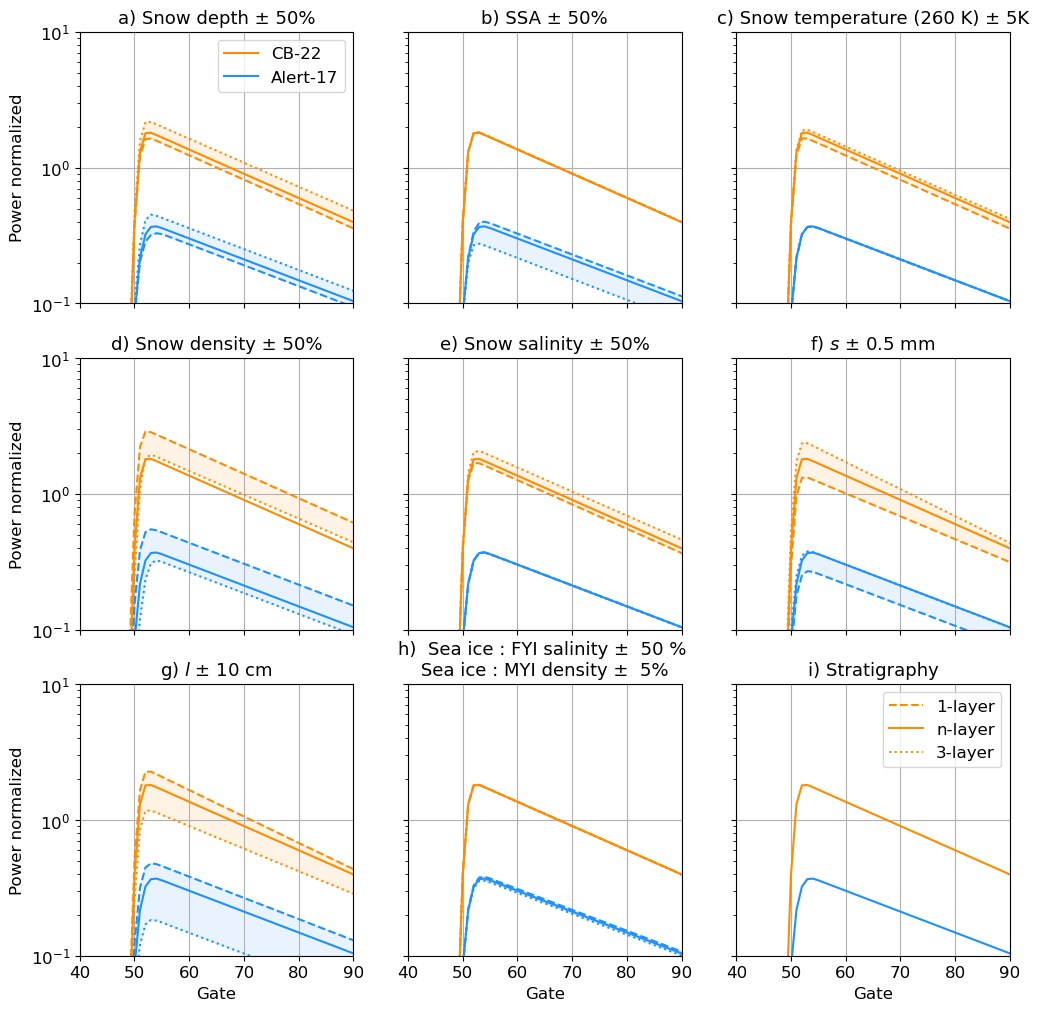

In [55]:
#generate x fro number of bins
x = range(0,len(res_CB_Ka_depth_p50))

# Plot results
plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex = True, sharey = True)
plt.rcParams.update({'font.size': 12})
ax1.set_title('a) Snow depth ± 50%', size = 13)
ax1.plot(res_CB_Ka_depth_p50, linestyle = '--',color = 'darkorange')
ax1.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange', label = 'CB-22')
ax1.plot(res_CB_Ka_depth_m50, linestyle = ':',color = 'darkorange')
ax1.fill_between(x, y1 = res_CB_Ka_depth_p50, y2 = res_CB_Ka_depth_m50, alpha =0.1, color = 'darkorange')

ax1.plot(res_A_Ka_depth_p50, linestyle = '--',color = 'dodgerblue')
ax1.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue', label = 'Alert-17')
ax1.plot(res_A_Ka_depth_m50, linestyle = ':',color = 'dodgerblue')
ax1.fill_between(x, y1 = res_A_Ka_depth_p50, y2 = res_A_Ka_depth_m50, alpha =0.1, color = 'dodgerblue')
ax1.legend()
#ax1.set_xlim(155,190)
ax1.set_ylabel('Power normalized')
ax1.grid()


ax2.set_title('b) SSA ± 50%', size = 13)
ax2.plot(res_CB_Ka_ssa_p20, linestyle = '--',color = 'darkorange')
ax2.plot(mean_simu_CB_Ka/0.5e-14,color = 'darkorange', label = 'FYI')
ax2.plot(res_CB_Ka_ssa_m20, linestyle = ':',color = 'darkorange')

ax2.plot(res_A_Ka_ssa_p20, linestyle = '--',color = 'dodgerblue')
ax2.plot(mean_simu_A_Ka/0.5e-14,color = 'dodgerblue', label = 'MYI')
ax2.plot(res_A_Ka_ssa_m20, linestyle = ':',color = 'dodgerblue')
ax2.fill_between(x, y1 = res_A_Ka_ssa_p20, y2 = res_A_Ka_ssa_m20, alpha =0.1, color = 'dodgerblue')
ax2.grid()
#ax2.set_xlim(155,190)

# ax8.set_title('c) Microstructure', size = 13)
# ax8.plot(res_CB_Ka_ind, linestyle = '--',color = 'darkorange', label = 'IND')
# ax8.plot(mean_simu_CB_Ka/0.5e-14,color = 'darkorange', label = 'EXP')
# ax8.plot(res_CB_Ka_shs, linestyle = ':',color = 'darkorange', label = 'SHS')

# ax8.plot(res_A_Ka_ind, linestyle = '--',color = 'dodgerblue')
# ax8.plot(mean_simu_A_Ka/0.5e-14,color = 'dodgerblue')
# ax8.plot(res_A_Ka_shs, linestyle = ':',color = 'dodgerblue')
# ax8.legend()
# ax8.set_ylabel('Power Normalized (MYI)')
# ax8.grid()
# #ax8.set_xlim(155,190)


ax3.set_title('c) Snow temperature (260 K) ± 5K', size = 13)
ax3.plot(res_CB_Ka_temp_p10, linestyle = '--',color = 'darkorange')
ax3.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange')
ax3.plot(res_CB_Ka_temp_m10, linestyle = ':',color = 'darkorange')
ax3.fill_between(x, y1 = res_CB_Ka_temp_p10, y2 = res_CB_Ka_temp_m10, alpha =0.1, color = 'darkorange')

ax3.plot(res_A_Ka_temp_p10, linestyle = '--',color = 'dodgerblue')
ax3.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue')
ax3.plot(res_A_Ka_temp_m10, linestyle = ':',color = 'dodgerblue')
ax3.fill_between(x, y1 = res_A_Ka_temp_p10, y2 = res_A_Ka_temp_m10, alpha =0.1, color = 'dodgerblue')
ax3.grid()
#ax3.set_xlim(155,190)


ax4.set_title('d) Snow density ± 50%', size = 13)
ax4.plot(res_CB_Ka_density_p20, linestyle = '--',color = 'darkorange')
ax4.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange', label = 'FYI ± 50%')
ax4.plot(res_CB_Ka_density_m20, linestyle = ':',color = 'darkorange')
ax4.fill_between(x, y1 = res_CB_Ka_density_p20, y2 = res_CB_Ka_density_m20, alpha =0.1, color = 'darkorange')

ax4.plot(res_A_Ka_density_p20, linestyle = '--',color = 'dodgerblue')
ax4.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax4.plot(res_A_Ka_density_m20, linestyle = ':',color = 'dodgerblue')
ax4.fill_between(x, y1 = res_A_Ka_density_p20, y2 = res_A_Ka_density_m20, alpha =0.1, color = 'dodgerblue')
#ax8.legend()
ax4.grid()
ax4.set_ylabel('Power normalized')
#ax4.set_xlim(155,190)


ax5.set_title('e) Snow salinity ± 50%', size = 13)
ax5.plot(res_CB_Ka_salt_p50, linestyle = '--',color = 'darkorange')
ax5.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange', label = 'FYI ± 50%')
ax5.plot(res_CB_Ka_salt_m50, linestyle = ':',color = 'darkorange')
ax5.fill_between(x, y1 = res_CB_Ka_salt_p50, y2 = res_CB_Ka_salt_m50, alpha =0.1, color = 'darkorange')

ax5.plot(res_A_Ka_salt_p50, linestyle = '--',color = 'dodgerblue')
ax5.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax5.plot(res_A_Ka_salt_m50, linestyle = ':',color = 'dodgerblue')
ax5.fill_between(x, y1 = res_A_Ka_salt_p50, y2 = res_A_Ka_salt_m50, alpha =0.1, color = 'dodgerblue')
#ax8.legend()
ax5.grid()
#ax5.set_xlim(155,190)

ax6.set_title('f) $s$ ± 0.5 mm', size =13)
ax6.plot(res_CB_Ka_rough_p1, linestyle = '--',color = 'darkorange')
ax6.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange', label = 'FYI ± 50%')
ax6.plot(res_CB_Ka_rough_m1, linestyle = ':',color = 'darkorange')
ax6.fill_between(x, y1 = res_CB_Ka_rough_p1, y2 = res_CB_Ka_rough_m1, alpha =0.1, color = 'darkorange')

ax6.plot(res_A_Ka_rough_p1, linestyle = '--',color = 'dodgerblue')
ax6.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax6.plot(res_A_Ka_rough_m1, linestyle = ':',color = 'dodgerblue')
ax6.fill_between(x, y1 = res_A_Ka_rough_p1, y2 = res_A_Ka_rough_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax6.grid()


ax7.set_title('g) $l$ $\pm$ 10 cm', size =13)
ax7.plot(res_CB_Ka_rough_s_p1, linestyle = '--',color = 'darkorange')
ax7.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange', label = 'FYI ± 50%')
ax7.plot(res_CB_Ka_rough_s_m1, linestyle = ':',color = 'darkorange')
ax7.fill_between(x, y1 = res_CB_Ka_rough_s_p1, y2 = res_CB_Ka_rough_s_m1, alpha =0.1, color = 'darkorange')

ax7.plot(res_A_Ka_rough_s_p1, linestyle = '--',color = 'dodgerblue')
ax7.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax7.plot(res_A_Ka_rough_s_m1, linestyle = ':',color = 'dodgerblue')
ax7.fill_between(x, y1 = res_A_Ka_rough_s_p1, y2 = res_A_Ka_rough_s_m1, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
#ax6.set_xlim(155,190)
ax7.set_xlabel('Gate')
ax7.grid()
ax7.set_ylabel('Power normalized')
#ax6.set_ylim(0,0.5)

ax8.set_title('h)  Sea ice : FYI salinity ±  50 % \n Sea ice : MYI density ±  5% ', size =13)
ax8.plot(res_CB_Ka_vf_p1, linestyle = '--',color = 'darkorange')
ax8.plot(mean_simu_CB_Ka/0.5e-14, color = 'darkorange', label = 'FYI ± 50%')
ax8.plot(res_CB_Ka_vf_m1, linestyle = ':',color = 'darkorange')
ax8.fill_between(x, y1 = res_CB_Ka_vf_p1, y2 = res_CB_Ka_vf_m1, alpha =0.1, color = 'darkorange')

ax8.plot(res_A_Ka_vf_p1, linestyle = '--',color = 'dodgerblue')
ax8.plot(mean_simu_A_Ka/0.5e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax8.plot(res_A_Ka_vf_m1, linestyle = ':',color = 'dodgerblue')
ax8.fill_between(x, y1 = res_A_Ka_vf_p1, y2 = res_A_Ka_vf_m1, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
#ax6.set_xlim(155,190)
ax8.set_xlabel('Gate')
ax8.grid()
#ax6.set_ylim(0,0.5)

ax9.set_title('i) Stratigraphy', size = 13)
ax9.plot(res_CB_Ka_one, linestyle = '--',color = 'darkorange', label = '1-layer')
ax9.plot(mean_simu_CB_Ka/0.5e-14,color = 'darkorange', label = 'n-layer')
ax9.plot(res_CB_Ka_three, linestyle = ':',color = 'darkorange', label = '3-layer')

ax9.plot(res_A_Ka_one, linestyle = '--',color = 'dodgerblue')
ax9.plot(mean_simu_A_Ka/0.5e-14,color = 'dodgerblue')
ax9.plot(res_A_Ka_three, linestyle = ':',color = 'dodgerblue')
ax9.legend()
ax9.grid()
ax9.set_xlabel('Gate')
#ax9.set_xlim(155,190)

ax1.set_yscale('log')
ax1.set_ylim(10e-2, 10)
ax1.set_xlim(40,90)


# plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sensitivity_analysis_Ka.png',
#              dpi=300, format='png', bbox_inches='tight')